In [1]:
import geopandas as gpd
from geopandas.tools import overlay
import os
import matplotlib.pyplot as plt
import boto3
import zipfile
import sys
import pandas as pd
from shapely.geometry import Point

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.write_metadata import (
    append_metadata
)

In [4]:
def reproject_csv_coordinates(file_name, aws_dir, output_file_name, lon='', lat=''):
    s3_client = boto3.client('s3')  
    bucket_name = 'ca-climate-index'  

    # Specify the S3 key (path + file) to download
    s3 = f'{aws_dir}/{file_name}'

    print('Pulling data')
    if not os.path.exists(file_name):
        # File not found locally, download from S3
        print('This can take a good bit, depending on file size')
        s3_client.download_file(bucket_name, s3, file_name)

    print(f'Download complete: {file_name}')

    csv_data = pd.read_csv(file_name)

    
    print('pulling census tract data from AWS..')
    print('')
    census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
    ca_boundaries = gpd.read_file(census_shp_dir)
    print("Original CRS of Census Tracts Data:")
    print(ca_boundaries.crs)
    print('')
    
    # Create Point geometries from latitude and longitude
    geometry = [Point(xy) for xy in zip(csv_data[lon], csv_data[lat])]
    print(f'Converting {file_name} to shp file...')
    print('')
    gdf = gpd.GeoDataFrame(csv_data, geometry=geometry)
    print('Conversion complete')
    print('')

    # Perform spatial join
    print('Assigning a crs for new shp data')
    gdf = gdf.set_crs('4269')

    reproject_gdf = gdf.to_crs(ca_boundaries.crs)

    print('New crs is:', reproject_gdf.crs)

    joined_data = gpd.sjoin(reproject_gdf, ca_boundaries, how='left', predicate='within')

    # Plot the census tracts
    ca_boundaries.plot(figsize=(10, 10), color='white', edgecolor='black')

    # Plot the joined data points
    joined_data.plot(ax=plt.gca(), color='red', markersize=5)

    plt.title('Census Tracts with Joined Data Points')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    '''
    print('Now clipping the dataset to CA boundaries')
    # Clip using 'ca_boundaries'
    clipped_gdf = overlay(joined_data, ca_boundaries, how='intersection')
    print('')

    # Plot the census tracts
    ca_boundaries.plot(figsize=(10, 10), color='white', edgecolor='black')

    # Plot the joined data points
    clipped_gdf.plot(ax=plt.gca(), color='red', markersize=5)
    plt.title('Census Tracts with Joined Data Points, after Clipping')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    '''

    print('Writing reprojected data to .gpkg file, this can take a while..')
    print('')
    # write the reprojected file to disk - still looking for a way around this
    if not os.path.exists(f'{output_file_name}.gpkg'):
        joined_data.to_file(f"{output_file_name}.gpkg", driver="GPKG")
    print('Complete, now uploading to aws..')

    dest_path = aws_dir.replace('1_pull_data','2b_reproject')

    # Upload the saved .prj file to AWS
    with open(output_file_name+'.gpkg', 'rb') as data:
        s3_client.upload_fileobj(data, bucket_name, f"{dest_path}/{output_file_name}.gpkg")
        print(f"Merged and sorted files called {output_file_name} uploaded to AWS in {dest_path}")
            
    os.remove(file_name)
    os.remove(output_file_name+'.gpkg')

This can take a good bit, depending on file size
Download complete: GAMA_division_drinking_water_2020_2024.csv
pulling census tract data from AWS..

Original CRS of Census Tracts Data:
EPSG:4269

Converting GAMA_division_drinking_water_2020_2024.csv to shp file...

Conversion complete

Assigning a crs for new shp data
New crs is: EPSG:4269


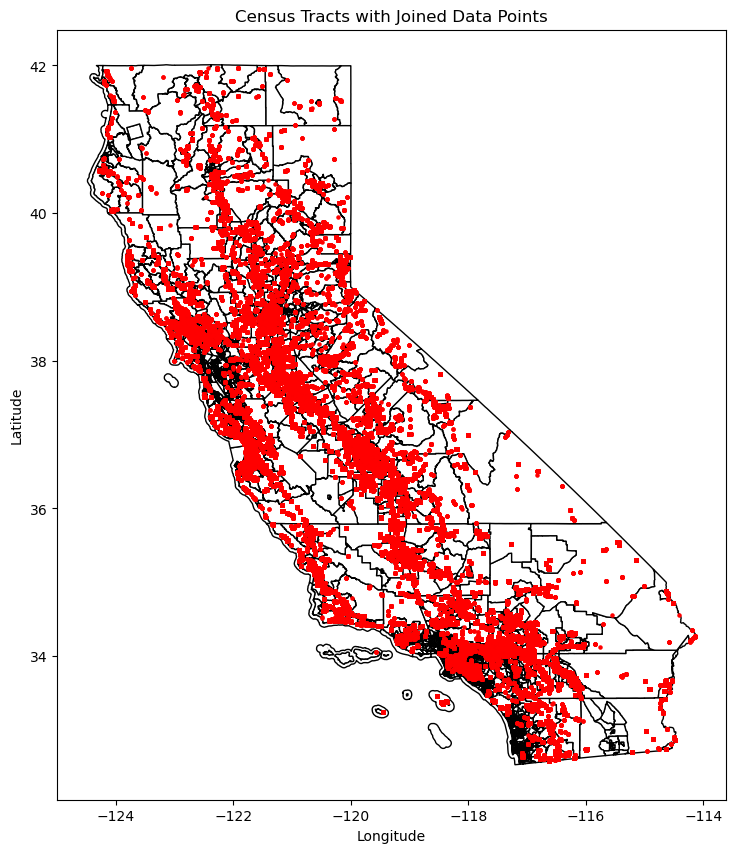

Writing reprojected data to .gpkg file, this can take a while..

Complete, now uploading to aws..
Merged and sorted files called GAMA_division_drinking_water_reproject uploaded to AWS in 2b_reproject/governance/natural_resource_conservation/ca_state_water_resources_board


In [3]:
file_name = 'GAMA_division_drinking_water_2020_2024.csv'
aws_dir = "1_pull_data/governance/natural_resource_conservation/ca_state_water_resources_board"
dataset_lon= 'gm_longitude'
dataset_lat= 'gm_latitude'
output_file_name = 'GAMA_division_drinking_water_reproject'

reproject_csv_coordinates(file_name, aws_dir, output_file_name, dataset_lon, dataset_lat)